# IF3170 Artificial Intelligence | Tugas Besar 2

Group Number: 31 - Kolmogorov-Arnold

Group Members:
- Roby Pratama Sitepu (13121142)
- Muhammad Fadli Alfarizi (13121140)
- Muhammad Arviano Yuono (13621034)
- Hafizh Renanto Akhmad (13621060)

## Import Libraries

In [4]:
from src import CustomTransformer


def reset_import():
    for module_name in list(sys.modules.keys()):
        if 'src' in module_name:
            del sys.modules[module_name]
            # print(f"removed module: {module_name}")


def check_for_completeness(data):
    print(data.shape)
    count = data.isna().sum().sum()

    if count > 0:
        raise Exception(f'\n{count} missing values found')


def inspect(df, features=None):
    for feature in features if features is not None else df.columns:
        print(f"feature = '{feature}'")
        print(f"count unique values = {df[feature].nunique()}")
        print(f"unique values: {df[feature].unique()}")
        print(f"missing values: {df[feature].isna().sum()}\n\n")


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

reset_import()

## Import Dataset

In [5]:
train_file_id = ['1sLJLWnim9A34A8hpQwZ9PxVhMJPOrN9d', '1GzheGwc1mG6z_M_kYUOMMPkE2QQrj0eW',
                 '1BunbVg1gBwI9v8h_6FxUMXJcuJDmnmMR', '1gkIqZAd5Aza8F8-2MzMO6t53gLEUYquj',
                 '1p38XDB0XStCbYKYVBi-Pmi2BunD6FY6J']

test_file_id = ['1TdeZx1bhHL8340emZhz8rW80016kdum3', '1Hg1_obL7mpwjN9gN0g1Me4jMlo8LGmVn',
                '1G8spITfMGnVry6XJGz3ONg3N-CFXltrI', '1NFcFBcHVj3LguL9BRC39HuAZTif2ws_8',
                '1tfmJu2HoeAePv7qKvIjAGETaqWkkhdbj']

X = pd.read_csv(f"https://drive.google.com/uc?id={train_file_id[0]}")
y = pd.read_csv('https://drive.google.com/uc?id=1Dt9cKiT1y1cysxyJGlcnnEkms8ibSjCq')[['attack_cat', 'id']]
for file_id in train_file_id[1:]:
    X = pd.merge(X, pd.read_csv(f"https://drive.google.com/uc?id={file_id}"), on='id')

shuffled = pd.merge(X, y, on='id').sample(frac=1, random_state=42).reset_index(drop=True)

X = shuffled.drop(columns=['attack_cat'])
y = shuffled[['attack_cat', 'id']]

X.set_index('id', inplace=True)
y.set_index('id', inplace=True)

categorical_features = ['proto', 'state', 'service', 'is_sm_ips_ports', 'is_ftp_login']
numerical_features = [col for col in X.columns if
                      col not in categorical_features and col != 'attack_cat' and col != 'id']

In [ ]:
X_test = pd.read_csv(f"https://drive.google.com/uc?id={test_file_id[0]}")
for file_id in test_file_id[1:]:
    X_test = pd.merge(X_test, pd.read_csv(f"https://drive.google.com/uc?id={file_id}"), on='id')

# Exploratory Data Analysis (Optional)

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

In [3]:
# Write your code here

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
for feature in categorical_features:
    unique_values_X_train = X_train[feature].dropna().nunique()
    unique_values_X_val = X_val[feature].dropna().nunique()

    if unique_values_X_train != unique_values_X_val:
        print(f"Feature '{feature}' has different unique values: "
              f"{unique_values_X_train} in X_train and {unique_values_X_val} in X_val.")
        vals = list(set(X_train[feature].unique().tolist()) - set(X_val[feature].unique().tolist()))
        for val in vals:
            print(f"{val} in column '{feature}' {(X_train[feature] == val).sum()} times")

            y_values = y_train[X_train[feature] == val]
            print(f"corresponding y values for {val} in column '{feature}': {y_values['attack_cat'].tolist()}")


Feature 'proto' has different unique values: 133 in X_train and 132 in X_val.
rtp in column 'proto' 1 times
corresponding y values for rtp in column 'proto': ['Normal']
Feature 'state' has different unique values: 8 in X_train and 7 in X_val.
URN in column 'state' 1 times
corresponding y values for URN in column 'state': ['Normal']
PAR in column 'state' 1 times
corresponding y values for PAR in column 'state': ['Normal']


In [8]:
print(len(numerical_features))

for col in numerical_features:
    print(f"Unique values in '{col}': {X_train[col].nunique()}")

36
Unique values in 'ct_state_ttl': 5
Unique values in 'ct_flw_http_mthd': 11
Unique values in 'ct_ftp_cmd': 4
Unique values in 'ct_srv_src': 52
Unique values in 'ct_srv_dst': 52
Unique values in 'ct_dst_ltm': 49
Unique values in 'ct_src_ltm': 50
Unique values in 'ct_src_dport_ltm': 47
Unique values in 'ct_dst_sport_ltm': 32
Unique values in 'ct_dst_src_ltm': 54
Unique values in 'dur': 51381
Unique values in 'sbytes': 5617
Unique values in 'dbytes': 5187
Unique values in 'sttl': 11
Unique values in 'dttl': 5
Unique values in 'sloss': 335
Unique values in 'dloss': 299
Unique values in 'sload': 55845
Unique values in 'dload': 52894
Unique values in 'spkts': 409
Unique values in 'dpkts': 377
Unique values in 'swin': 9
Unique values in 'dwin': 6
Unique values in 'stcpb': 50930
Unique values in 'dtcpb': 50747
Unique values in 'smean': 1328
Unique values in 'dmean': 1280
Unique values in 'trans_depth': 10
Unique values in 'response_body_len': 1877
Unique values in 'sjit': 52735
Unique values

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [ ]:
reset_import()

from src.compose import CustomTransformer

preprocessor = CustomTransformer(
    transformers=[
        (SimpleImputer(strategy='mean'), numerical_features),
        (SimpleImputer(strategy='most_frequent'), categorical_features),
    ]
)

X_train_completed = preprocessor.fit_transform(X_train)
X_val_completed = preprocessor.transform(X_val)

check_for_completeness(X_train_completed)
check_for_completeness(X_val_completed)

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [ ]:
reset_import()

from src.compose import CustomTransformer
from src.preprocessing.outlier.strategy import BoundOutlierHandlerStrategy

preprocessor = CustomTransformer(
    transformers=[
        (BoundOutlierHandlerStrategy(), numerical_features)
    ]
)

X_train_outliers_removed = preprocessor.fit_transform(X_train_completed)
X_val_outliers_removed = preprocessor.transform(X_val_completed)

check_for_completeness(X_train_outliers_removed)
check_for_completeness(X_val_outliers_removed)

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [ ]:
reset_import()

from src.preprocessing.duplicate import DropDuplicateHandlerStrategy

duplicate_handler = DropDuplicateHandlerStrategy()

X_train_duplicates_removed = duplicate_handler.fit_transform(X_train_outliers_removed)
X_val_duplicates_removed = duplicate_handler.transform(X_val_outliers_removed)

y_train_duplicates_removed = y_train.loc[X_train_duplicates_removed.index]
y_val_duplicates_removed = y_val.loc[X_val_duplicates_removed.index]

check_for_completeness(X_train_duplicates_removed)
check_for_completeness(X_val_duplicates_removed)

print(y_train_duplicates_removed.shape)
print(y_val_duplicates_removed.shape)

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:

   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.

   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [ ]:
reset_import()

from src.preprocessing.encoder import OneHotFeatureEncoderStrategy

preprocessor = CustomTransformer(
    transformers=[
        (OneHotFeatureEncoderStrategy(), categorical_features),
    ]
)

X_train_encoded = preprocessor.fit_transform(X_train_duplicates_removed)
X_val_encoded = preprocessor.transform(X_val_duplicates_removed)

check_for_completeness(X_train_encoded)
check_for_completeness(X_val_encoded)

In [ ]:
reset_import()

from src.preprocessing.selection.strategy import RandomForestFeatureSelectionHandlerStrategy

preprocessor = RandomForestFeatureSelectionHandlerStrategy(0.25)

X_train_selected = preprocessor.fit_transform(X_train_encoded, y_train_duplicates_removed['attack_cat'])
X_val_selected = preprocessor.transform(X_val_encoded)

check_for_completeness(X_train_selected)
check_for_completeness(X_val_selected)

selected_numerical_features = [feature for feature in X_train_selected.columns if feature in numerical_features]
selected_categorical_features = [feature for feature in X_train_selected.columns if
                                 feature not in selected_numerical_features]

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

In [ ]:
# Example

# from sklearn.base import BaseEstimator, TransformerMixin

# class FeatureEncoder(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):

#         # Fit the encoder here

#         return self

#     def transform(self, X):
#         X_encoded = X.copy()

#         # Encode the categorical variables here

#         return X_encoded

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [ ]:
reset_import()

from src.compose import CustomTransformer
from src.preprocessing.scale import ZScoreScaleHandlerStrategy

preprocessing = CustomTransformer(
    transformers=[
        (ZScoreScaleHandlerStrategy(), selected_numerical_features),
    ]
)

X_train_scaled = preprocessing.fit_transform(X_train_selected)
X_val_scaled = preprocessing.transform(X_val_selected)

check_for_completeness(X_train_scaled)
check_for_completeness(X_val_scaled)

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [ ]:
# already encoded before feature selection (random forest)

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [ ]:
from src.preprocessing.common import TransformerStrategy
from src.compose import PipelineProperty
from imblearn.over_sampling import SMOTE

from src.compose.io import IOTransformerStrategy

"""
pass fit()
transform(X, y)

modifies X, y
"""

class DataImbalanceTransformerStrategy(IOTransformerStrategy):
    def __init__(self, strategy: TransformerStrategy):
        super().__init__(strategy)

    def fit(self, pl_property: PipelineProperty):
        pass

    def transform(self, pl_property: PipelineProperty):
        pl_property.X_transformed, pl_property.y_transformed = self._strategy.transform(pl_property.X_transformed, pl_property.y_transformed)

    def fit_transform(self, pl_property: PipelineProperty):
        return self.transform(pl_property)

class SMOTEProxy(TransformerStrategy):
    def __init__(self, smote):
        self._smote = smote

    def fit(self, X, y):
        pass

    def transform(self, X, y):
        return self._smote.fit_resample(X, y)

    def fit_transform(self, X, y):
        return self._smote.fit_resample(X, y)


In [ ]:
preprocessor = SMOTEProxy(SMOTE(random_state=42))

X_train_balanced, y_train_balanced = preprocessor.fit_transform(X_train_selected, y_train_duplicates_removed)

check_for_completeness(X_train_balanced)
check_for_completeness(y_train_balanced)

### IV. Data Normalization

Data normalization is used to achieve a standard distribution. Without normalization, models or processes that rely on the assumption of normality may not work correctly. Normalization helps reduce the magnitude effect and ensures numerical stability during optimization.

### V. Dimensionality Reduction

Dimensionality reduction is a technique used in data preprocessing to reduce the number of input features (dimensions) in a dataset while retaining as much important information as possible. It is essential when dealing with high-dimensional data, where too many features can cause problems like increased computational costs, overfitting, and difficulty in visualization. Reducing dimensions simplifies the data, making it easier to analyze and improving the performance of machine learning models.

One of the main approaches to dimensionality reduction is feature extraction. Feature extraction creates new, smaller sets of features that capture the essence of the original data. Common techniques include:

1. **Principal Component Analysis (PCA)**: Converts correlated features into a smaller number of uncorrelated "principal components."
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A visualization-focused method to project high-dimensional data into 2D or 3D spaces.
3. **Autoencoders**: Neural networks that learn compressed representations of the data.

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [ ]:
# from sklearn.pipeline import Pipeline

# # Note: You can add or delete preprocessing components from this pipeline

# pipe = Pipeline([("missing", FeatureImputer()),
#                  ("featurecreator", FeatureCreator()),
#                  ("scaler", FeatureScaler()),
#                  ("encoder", FeatureEncoder())])

# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

In [ ]:
# # Your code should work up until this point
# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

or create your own here

In [8]:
reset_import()

from abc import ABC, abstractmethod
from src.preprocessing import TransformerStrategy


class Model(ABC):
    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass


class Proxy(TransformerStrategy):
    def __init__(self, model: Model):
        self._model = model

    @property
    def model(self):
        return self._model

    def fit(self, X, y):
        self._model.fit(X, y)

    def transform(self, X):
        return self._model.predict(X)

    def fit_transform(self, X, y):
        self.fit(X, y)

        return self.transform(X)

class SpecialProxy(TransformerStrategy):
    def __init__(self, model: Model):
        self._model = model

    @property
    def model(self):
        return self._model

    def fit(self, X, y):
        self._model.fit(X, y)

    def transform(self, X):
        return self._model.predict(X)

    def fit_transform(self, X, y):
        self.fit(X, y)

        return X.copy()


class SKLearnLabelEncoderProxy():
    def __init__(self):
        self._encoders = {}

    @abstractmethod
    def fit(self, X, y=None):
        for feature in X.columns:
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                     unknown_value=-1).fit(X[feature].values.reshape(-1, 1))
            self._encoders[feature] = encoder

    @abstractmethod
    def transform(self, X):
        X_transformed = X.copy()
        for feature in X_transformed.columns:
            X_transformed[feature] = self._encoders[feature].transform(X_transformed[feature].values.reshape(-1, 1))

        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)

        return self.transform(X)

from src.compose.io.IOTransformerStrategy import IOTransformerStrategy
from src.preprocessing.common import TransformerStrategy
from src.compose import PipelineProperty


class SpecialClassifierTransformerStrategy(IOTransformerStrategy):
    def __init__(self, strategy: TransformerStrategy):
        super().__init__(strategy)

    def fit(self, pl_property: PipelineProperty):
        self._strategy.fit(pl_property.X_transformed, pl_property.y_transformed)

    def transform(self, pl_property: PipelineProperty):
        pl_property.y_transformed = self._strategy.transform(pl_property.X_transformed)

    def fit_transform(self, pl_property: PipelineProperty):
        self._strategy.fit(pl_property.X_transformed, pl_property.y_transformed)

        return pl_property.X_transformed.copy()



# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `attack_cat`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [9]:
import pickle
import os
import json

# Define the directory and filename
directory_sklearn = './model/sklearn/'
directory_scratch = './model/scratch/'

In [10]:
from src.compose import CustomPipeline, PipelineProperty, CustomTransformer, PipelineComponent
from src.preprocessing.outlier import OutlierHandler, BoundOutlierHandlerStrategy
from src.preprocessing.selection import FeatureSelectionHandler, RandomForestFeatureSelectionHandlerStrategy
from src.preprocessing.missing import MissingValueHandler
from src.preprocessing.duplicate import DuplicateHandler, DropDuplicateHandlerStrategy
from src.preprocessing.scale import ScaleHandler, ZScoreScaleHandlerStrategy
from src.compose.io import ClassifierTransformerStrategy, LabelEncoderIOTransformerStrategy

In [11]:
def compare_models(pipelines, X_data=X, y_data=y, fold=True, X_data_test = None, y_data_test = None):

    if fold:
        # Create StratifiedKFold object.
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for pipeline in pipelines:
            count = 0
            f1_score_stratified = []
            
            for train_index, test_index in skf.split(X_data, y_data):
                
                #splitting
                X_train_fold, X_test_fold = X_data.iloc[train_index], X_data.iloc[test_index]
                y_train_fold, y_test_fold = y_data.iloc[train_index], y_data.iloc[test_index]
    
                #fit transform
                X_train_transformed, _ = pipeline.fit_transform(X_train_fold, y_train_fold)
                check_for_completeness(X_train_transformed)
    
                #predict
                _, y_predict_fold = pipeline.transform(X_test_fold)
    
                #validations
                
                f1_score_stratified.append(f1_score(y_true=y_test_fold[:len(y_predict_fold)], y_pred=y_predict_fold, average='macro'))
                report = classification_report(y_test_fold[:len(y_predict_fold)], y_predict_fold)
                print(f"classification report: \n{report}")
    
                count += 1  
                print(f"\nloop {count}: \nF1: {f1_score_stratified[count-1]}\n")
    
            # model performance

            # F1 score
            print('\nList of possible F1 score:', f1_score_stratified)
            print('\nMaximum F1 Score That can be obtained from this model is:',
                max(f1_score_stratified)*100, '%')
            print('\nMinimum F1 Score:',
                min(f1_score_stratified)*100, '%')
            print('\nOverall F1 Score:',
                np.mean(f1_score_stratified)*100, '%')
            print('\nStandard Deviation is:', np.std(f1_score_stratified)*100, '%')
            print('\n')

    
            
    else:
        for pipeline in pipelines:

            X_train_transformed, _ = pipeline.fit_transform(X_data, y_data)
    
            check_for_completeness(X_train_transformed)

            if X_data_test is not None:
                _, y_pred = pipeline.transform(X_data_test)
            
                if y_data_test is not None:
                    f1_macro = f1_score(y_data_test, y_pred, average='macro')
                    print(f"F1 Score (Macro): {f1_macro}")

                else :
                    return y_pred

## A. KNN

In [13]:
k_neighbours = [2,3,5]
batch_size = 250

### a. Sklearn

#### Euclidean distance

In [14]:
reset_import()

from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

for neighbor in k_neighbours:

    model = KNeighborsClassifier(n_neighbors=neighbor, metric='euclidean')

    knn_sklearn = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model = model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=True,
        only_once=['duplicate'])

    compare_models([knn_sklearn])

    # final model
    compare_models([knn_sklearn], fold=False)

    # Create the directory if it does not exist
    os.makedirs(directory_sklearn, exist_ok=True)
    model = knn_sklearn.get_component('classifier').io_strategy.strategy.model

    # Save the trained model to a .pkl file
    with open(os.path.join(directory_sklearn, f"knn_euc_k_{neighbor}.pkl"), 'wb') as file:
        pickle.dump(model, file)

fit and transform: missing
fit and transform: duplicate
fit and transform: outliers
fit and transform: feature selection
fit and transform: feature scaling
fit and transform: encoder
fit and transform: classifier
transform: missing
transform: outliers
transform: feature selection
transform: feature scaling
transform: encoder
transform: classifier
(140272, 14)
transform: missing
transform: outliers
transform: feature selection
transform: feature scaling
transform: encoder
transform: classifier
classification report:                 precision    recall  f1-score   support

      Analysis       0.11      0.23      0.15       400
      Backdoor       0.06      0.11      0.08       349
           DoS       0.31      0.43      0.36      2453
      Exploits       0.65      0.61      0.63      6679
       Fuzzers       0.62      0.72      0.67      3637
       Generic       0.99      0.98      0.99      8000
        Normal       0.95      0.86      0.90     11200
Reconnaissance       0.90     

#### Minkowski distance

In [19]:
reset_import()

from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings('ignore')D

reset_import()

from src.compose import CustomPipeline
k_neighbours = [5]
for neighbor in k_neighbours:

    model = KNeighborsClassifier(n_neighbors=neighbor, metric = 'minkowski', p = 3)

    knn_sklearn_min = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model = model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    compare_models([knn_sklearn_min])

(140272, 14)
classification report:                 precision    recall  f1-score   support

      Analysis       0.23      0.12      0.16       400
      Backdoor       0.16      0.06      0.09       349
           DoS       0.32      0.38      0.34      2453
      Exploits       0.64      0.71      0.67      6679
       Fuzzers       0.65      0.65      0.65      3637
       Generic       1.00      0.98      0.99      8000
        Normal       0.92      0.89      0.90     11200
Reconnaissance       0.84      0.68      0.75      2098
     Shellcode       0.52      0.38      0.44       227
         Worms       0.29      0.19      0.23        26

      accuracy                           0.78     35069
     macro avg       0.56      0.51      0.52     35069
  weighted avg       0.79      0.78      0.78     35069


loop 1: 
F1: 0.5231555050925979

(140273, 14)
classification report:                 precision    recall  f1-score   support

      Analysis       0.18      0.11      0.14     

#### Manhattan distance

In [ ]:
reset_import()

from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

for neighbor in k_neighbours:

    model = KNeighborsClassifier(n_neighbors=neighbor, metric='manhattan')

    knn_sklearn_manh = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model = model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    compare_models([knn_sklearn_manh])

### b. scratch

#### Euclidean distance (Best)

In [62]:
reset_import()

from src.algorithm.neighbors import KNearestNeighborsClassifier
from src.algorithm.neighbors.strategy import EuclideanDistanceStrategy

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline
k_neighbours = [5]
for neighbor in k_neighbours:
        
    model = KNearestNeighborsClassifier(n_neighbors=neighbor, distance_strategy=EuclideanDistanceStrategy(), batch_size=batch_size)

    knn_scratch_euclidean = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model = model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    compare_models([knn_scratch_euclidean])

batch: 1 of 134
batch: 2 of 134
batch: 3 of 134
batch: 4 of 134
batch: 5 of 134
batch: 6 of 134
batch: 7 of 134
batch: 8 of 134
batch: 9 of 134
batch: 10 of 134
batch: 11 of 134
batch: 12 of 134
batch: 13 of 134
batch: 14 of 134
batch: 15 of 134
batch: 16 of 134
batch: 17 of 134
batch: 18 of 134
batch: 19 of 134
batch: 20 of 134
batch: 21 of 134
batch: 22 of 134
batch: 23 of 134
batch: 24 of 134
batch: 25 of 134
batch: 26 of 134
batch: 27 of 134
batch: 28 of 134
batch: 29 of 134
batch: 30 of 134
batch: 31 of 134
batch: 32 of 134
batch: 33 of 134
batch: 34 of 134
batch: 35 of 134
batch: 36 of 134
batch: 37 of 134
batch: 38 of 134
batch: 39 of 134
batch: 40 of 134
batch: 41 of 134
batch: 42 of 134
batch: 43 of 134
batch: 44 of 134
batch: 45 of 134
batch: 46 of 134
batch: 47 of 134
batch: 48 of 134
batch: 49 of 134
batch: 50 of 134
batch: 51 of 134
batch: 52 of 134
batch: 53 of 134
batch: 54 of 134
batch: 55 of 134
batch: 56 of 134
batch: 57 of 134
batch: 58 of 134
batch: 59 of 134
batch:

KeyboardInterrupt: 

#### Manhattan distance

In [ ]:
reset_import()

from src.algorithm.neighbors import KNearestNeighborsClassifier
from src.algorithm.neighbors.strategy import ManhattanDistanceStrategy

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline
k_neighbours = [5]
for neighbor in k_neighbours:

    model = KNearestNeighborsClassifier(n_neighbors=neighbor, distance_strategy=ManhattanDistanceStrategy(), batch_size=batch_size)

    knn_scratch_manhattan = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model = model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    compare_models([knn_scratch_manhattan])
    
    # compare_models([knn_scratch_manhattan], X_data=X[:X.shape[0]//20], y_data=y[:X.shape[0]//20])

    # compare_models([knn_scratch_euclidean], fold=False)

    # Create the directory if it does not exist
    os.makedirs(directory_scratch, exist_ok=True)
    knn_scratch_euclidean.get_component('classifier').io_strategy.strategy.model.save(f"{directory_scratch}knn_manh_k_{neighbor}.json")

batch: 1 of 534


#### Minkowski distance

In [ ]:
reset_import()

from src.algorithm.neighbors import KNearestNeighborsClassifier
from src.algorithm.neighbors.strategy import MinkowskiDistanceStrategy

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline
k_neighbours = [5]
for neighbor in k_neighbours:
    model = KNearestNeighborsClassifier(n_neighbors=neighbor, distance_strategy=MinkowskiDistanceStrategy(p = 3), batch_size=batch_size)

    knn_scratch_minkowski = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model=model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    compare_models([knn_scratch_minkowski], X_data=X[:X.shape[0]//4], y_data=y[:X.shape[0]//4])

    # compare_models([knn_scratch_euclidean], fold=False)

    # # Create the directory if it does not exist
    # os.makedirs(directory_scratch, exist_ok=True)
    # knn_scratch_euclidean.get_component('classifier').io_strategy.strategy.model.save(f"{directory_scratch}knn_mink_k_{neighbor}.json")

batch: 1 of 534
batch: 2 of 534
batch: 3 of 534
batch: 4 of 534
batch: 5 of 534
batch: 6 of 534


## B. Naive Bayes

### a. Sklearn

In [13]:
var_smooths = [10 ** -i for i in range(1, 17)]

In [14]:
reset_import()

from sklearn.naive_bayes import GaussianNB

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

for var_smooth in var_smooths:
    model = GaussianNB(var_smoothing=var_smooth)

    nb_sklearn = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(   
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model=model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    print("Sklearn Naive Bayes Model Performance")
    compare_models([nb_sklearn])

    # final model
    # compare_models([nb_sklearn], fold=False)

    # Create the directory if it does not exist
    # os.makedirs(directory_sklearn, exist_ok=True)
    # model = nb_sklearn.get_component('classifier').io_strategy.strategy.model
        
    # # Save the trained model to a .pkl file
    # with open(os.path.join(directory_sklearn, f"nb_var_{var_smooth}.pkl"), 'wb') as file:
    #     pickle.dump(model, file)

Sklearn Naive Bayes Model Performance
(140272, 14)
classification report: 
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       400
      Backdoor       0.00      0.00      0.00       349
           DoS       0.22      0.14      0.17      2453
      Exploits       0.00      0.00      0.00      6679
       Fuzzers       0.00      0.00      0.00      3637
       Generic       0.25      1.00      0.40      8000
        Normal       0.01      0.00      0.00     11200
Reconnaissance       0.00      0.00      0.00      2098
     Shellcode       0.00      0.00      0.00       227
         Worms       0.00      0.00      0.00        26

      accuracy                           0.24     35069
     macro avg       0.05      0.11      0.06     35069
  weighted avg       0.07      0.24      0.10     35069


loop 1: 
F1: 0.057282197657391766

(140273, 14)
classification report: 
                precision    recall  f1-score   support

      An

In [23]:
# Create the directory if it does not exist
os.makedirs(directory_sklearn, exist_ok=True)
model = nb_sklearn.get_component('classifier').io_strategy.strategy.model
    
# Save the trained model to a .pkl file
with open(os.path.join(directory_sklearn, 'nb.pkl'), 'wb') as file:
    pickle.dump(model, file)


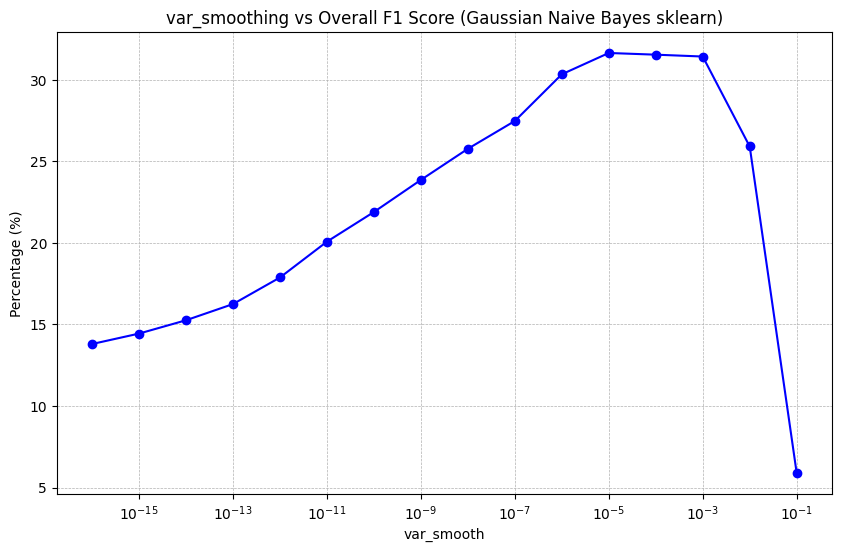

In [18]:
import matplotlib.pyplot as plt

# Given data
var_smooths = [10 ** -i for i in range(1, 17)]
percentages = [
    5.894385758453359, 25.916030340428343, 31.431950350836534, 
    31.545627802567523, 31.649347336985556, 30.34337906460845, 
    27.480465100837893, 25.77502506656532, 23.86679247242983, 
    21.899274449213628, 20.080980020938462, 17.883998275705277, 
    16.253248964063566, 15.261476406152982, 14.443815477909705, 
    13.803575178201626
]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(var_smooths, percentages, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Logarithmic scale for var_smooths
plt.xlabel('var_smooth')
plt.ylabel('Percentage (%)')
plt.title('var_smoothing vs Overall F1 Score (Gaussian Naive Bayes sklearn)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### b. Scratch

In [24]:
reset_import()

from src.algorithm import GaussianNaiveBayes

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

for var_smooth in var_smooths:
    model = GaussianNaiveBayes(var_smoothing=var_smooth)

    nb_scratch = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model=model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    print("Scratch Gaussian Naive Bayes Model Performance")
    compare_models([nb_scratch])

    # final model
    compare_models([nb_scratch], fold=False)

    # Create the directory if it does not exist
    os.makedirs(directory_scratch, exist_ok=True)
    nb_scratch.get_component('classifier').io_strategy.strategy.model.save(f"{directory_scratch}nb_smooth_{var_smooth}.json")

Scratch Gaussian Naive Bayes Model Performance
(140272, 14)

loop 1: 
F1: 0.057282197657391766

(140273, 14)

loop 2: 
F1: 0.06032992879844562

(140273, 14)

loop 3: 
F1: 0.059220599185433966

(140273, 14)

loop 4: 
F1: 0.05895150894561553

(140273, 14)

loop 5: 
F1: 0.05893505333578107


List of possible F1 score: [np.float64(0.057282197657391766), np.float64(0.06032992879844562), np.float64(0.059220599185433966), np.float64(0.05895150894561553), np.float64(0.05893505333578107)]

Maximum F1 Score That can be obtained from this model is: 6.032992879844562 %

Minimum F1 Score: 5.728219765739176 %

Overall F1 Score: 5.894385758453359 %

Standard Deviation is: 0.09756053603067119 %


(175341, 14)
Scratch Gaussian Naive Bayes Model Performance
(140272, 14)

loop 1: 
F1: 0.2596090063248274

(140273, 14)

loop 2: 
F1: 0.2584726495220252

(140273, 14)

loop 3: 
F1: 0.25972200068162893

(140273, 14)

loop 4: 
F1: 0.2580964222322839

(140273, 14)

loop 5: 
F1: 0.2599097147617885


List of possi

From the results above, we get the F1 score vs `var_smoothing` parameter plot as

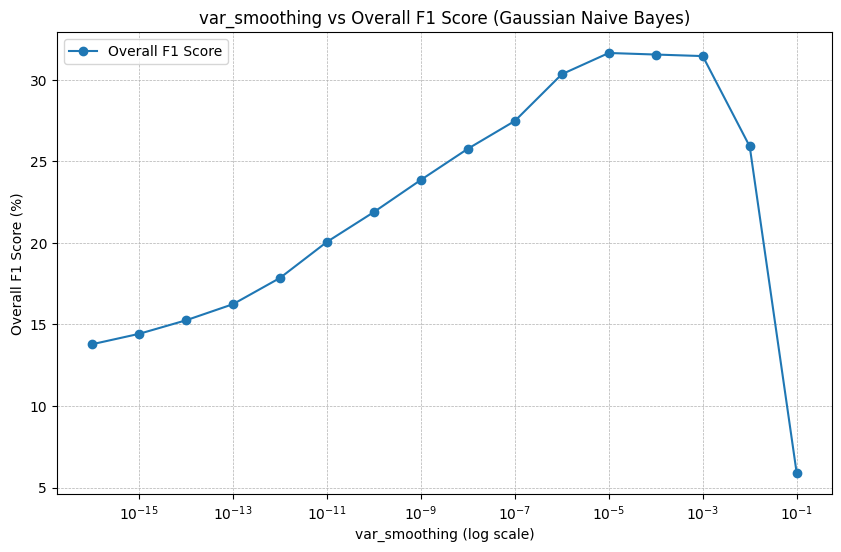

In [17]:
import matplotlib.pyplot as plt
var_smooths = [10 ** -i for i in range(1, 17)]
overall_f1_scores = [
    5.894385758453359, 25.91619587045108, 31.453311589503556, 31.547789624494392,
    31.64350392104105, 30.341565070382675, 27.47675849054384, 25.7729142574317,
    23.864307442831535, 21.894075306547006, 20.06255059042638, 17.85254050224761,
    16.244187793385187, 15.256226191838584, 14.425254976786128, 13.78796621331057
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(var_smooths, overall_f1_scores, marker='o', label='Overall F1 Score')
plt.xscale('log')  # Logarithmic scale for var_smoothing
plt.xlabel('var_smoothing (log scale)')
plt.ylabel('Overall F1 Score (%)')
plt.title('var_smoothing vs Overall F1 Score (Gaussian Naive Bayes)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


## C. ID3

### a. Sklearn

In [6]:
depths = [5, 10, None]

In [12]:
from sklearn.tree import DecisionTreeClassifier
from src.algorithm import IterativeDichotomiser3

reset_import()

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

for i, max_depth in enumerate(depths):
    model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth)

    ID3_sklearn = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('encoder', PipelineComponent(strategy=None).set_io_strategy(
            LabelEncoderIOTransformerStrategy(strategy=CustomTransformer(transformers=[
                (SKLearnLabelEncoderProxy(), categorical_features),
            ])),
        )),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model= model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])


    print("Sklearn Decision Tree Model Performance")
    compare_models([ID3_sklearn])

    # final model
    # compare_models([ID3_sklearn], fold=False)

    # Create the directory if it does not exist
    os.makedirs(directory_sklearn, exist_ok=True)
    model = ID3_sklearn.get_component('classifier').io_strategy.strategy.model
        
    # Save the trained model to a .pkl file
    with open(os.path.join(directory_sklearn, f"tree_max_{max_depth}.pkl"), 'wb') as file:
        pickle.dump(model, file)

Sklearn Decision Tree Model Performance
(140272, 14)
classification report: 
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       400
      Backdoor       0.00      0.00      0.00       349
           DoS       0.00      0.00      0.00      2453
      Exploits       0.54      0.89      0.67      6679
       Fuzzers       0.43      0.69      0.53      3637
       Generic       0.91      0.97      0.94      8000
        Normal       1.00      0.72      0.84     11200
Reconnaissance       0.64      0.48      0.55      2098
     Shellcode       0.00      0.00      0.00       227
         Worms       0.00      0.00      0.00        26

      accuracy                           0.72     35069
     macro avg       0.35      0.38      0.35     35069
  weighted avg       0.71      0.72      0.70     35069


loop 1: 
F1: 0.3525728445427488

(140273, 14)
classification report: 
                precision    recall  f1-score   support

      An

### b. Scratch

In [19]:
from src.algorithm import IterativeDichotomiser3

reset_import()

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

X_ID3 = X.copy()
X_ID3[categorical_features] = X_ID3[categorical_features].astype('str')

for i, max_depth in enumerate(depths):
    model = IterativeDichotomiser3(max_depth=max_depth)

    ID3_scratch = CustomPipeline(args=[
        ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
            (SimpleImputer(strategy='mean'), numerical_features),
            (SimpleImputer(strategy='most_frequent'), categorical_features)
        ]))),
        ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
        ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
            (BoundOutlierHandlerStrategy(), numerical_features)
        ]))),
        ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
            (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
        ]))),
        ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
        ('classifier', PipelineComponent(strategy=None).set_io_strategy(
            ClassifierTransformerStrategy(strategy=Proxy(model= model)))),
    ], pl_property=PipelineProperty(
        {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
        only_once=['duplicate'])

    # validation
    print(f"Scratch Decision Tree Model Performance at depth = {max_depth}")
    compare_models([ID3_scratch], X_data=X_ID3)

    # final model
    compare_models([ID3_scratch], X_data=X_ID3, fold=False)

    # Create the directory if it does not exist
    os.makedirs(directory_scratch, exist_ok=True)
    ID3_scratch.get_component('classifier').io_strategy.strategy.model.save(f"{directory_scratch}tree_max_depth_{max_depth}.json")

Scratch Decision Tree Model Performance at depth = 5
(140272, 14)

loop 1: 
F1: 0.4287626906088809

(140273, 14)

loop 2: 
F1: 0.43278748282279533

(140273, 14)

loop 3: 
F1: 0.43528667535803456

(140273, 14)

loop 4: 
F1: 0.4420156988660501

(140273, 14)

loop 5: 
F1: 0.44464231243900265


List of possible F1 score: [np.float64(0.4287626906088809), np.float64(0.43278748282279533), np.float64(0.43528667535803456), np.float64(0.4420156988660501), np.float64(0.44464231243900265)]

Maximum F1 Score That can be obtained from this model is: 44.464231243900265 %

Minimum F1 Score: 42.87626906088809 %

Overall F1 Score: 43.66989720189527 %

Standard Deviation is: 0.5859063638592655 %


(175341, 14)
Scratch Decision Tree Model Performance at depth = 10
(140272, 14)

loop 1: 
F1: 0.46570041661511385

(140273, 14)

loop 2: 
F1: 0.466328862415428

(140273, 14)

loop 3: 
F1: 0.4682732900385161

(140273, 14)

loop 4: 
F1: 0.47671343326885507

(140273, 14)

loop 5: 
F1: 0.48327164708438863


List of

## D. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

## E. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `attack_cat` column.

In [8]:
X_test = pd.read_csv(f"https://drive.google.com/uc?id={test_file_id[0]}")

for file_id in test_file_id[1:]:
    X_test = pd.merge(X_test, pd.read_csv(f"https://drive.google.com/uc?id={file_id}"), on='id')
    
X_test.set_index('id', inplace=True)

In [9]:
from src.algorithm import IterativeDichotomiser3

reset_import()

import warnings

warnings.filterwarnings('ignore')

reset_import()

from src.compose import CustomPipeline

X_ID3 = X.copy()
X_ID3[categorical_features] = X_ID3[categorical_features].astype('str')

max_depth = None
model = IterativeDichotomiser3(max_depth=max_depth)

ID3_submission = CustomPipeline(args=[
    ('missing', MissingValueHandler(strategy=CustomTransformer(transformers=[
        (SimpleImputer(strategy='mean'), numerical_features),
        (SimpleImputer(strategy='most_frequent'), categorical_features)
    ]))),
    ('duplicate', DuplicateHandler(strategy=DropDuplicateHandlerStrategy())),
    ('outliers', OutlierHandler(strategy=CustomTransformer(transformers=[
        (BoundOutlierHandlerStrategy(), numerical_features)
    ]))),
    ('feature selection', FeatureSelectionHandler(strategy=CustomTransformer(transformers=[
        (RandomForestFeatureSelectionHandlerStrategy(0.25), numerical_features),
    ]))),
    ('feature scaling', ScaleHandler(strategy=ZScoreScaleHandlerStrategy()), 'numerical_features'),
    ('classifier', PipelineComponent(strategy=None).set_io_strategy(
        ClassifierTransformerStrategy(strategy=Proxy(model= model)))),
], pl_property=PipelineProperty(
    {'numerical_features': numerical_features, 'categorical_features': categorical_features}), verbose=False,
    only_once=['duplicate'])

X_train_transformed, y_train_transformed = ID3_submission.fit_transform(X_ID3, y)

check_for_completeness(X_train_transformed)

X_test[categorical_features] = X_test[categorical_features].astype('str')
_, y_pred = ID3_submission.transform(X_test)

y_pred = pd.DataFrame(y_pred.reshape(len(y_pred),1))
y_pred.reset_index(inplace=True)  # Add index as 'id'
y_pred.columns = ['id', 'attack_cat']  # Rename columns

# Save to CSV
y_pred.to_csv('submission.csv', index=False)

fit and transform: missing
fit and transform: duplicate
fit and transform: outliers
fit and transform: feature selection
fit and transform: feature scaling
fit and transform: classifier
transform: missing
transform: outliers
transform: feature selection
transform: feature scaling
transform: classifier
(175341, 14)
transform: missing
transform: outliers
transform: feature selection
transform: feature scaling
transform: classifier


In [10]:
# Create the directory if it does not exist
os.makedirs(directory_scratch, exist_ok=True)
ID3_submission.get_component('classifier').io_strategy.strategy.model.save(f"{directory_scratch}submission.json")

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

1. Does my model perform better in predicting one class than the other? If so, why is that?
2. To each models I have tried, which performs the best and what could be the reason?
3. Is it better for me to impute or drop the missing data? Why?
4. Does feature scaling help improve my model performance?
5. Was there evidence of overfitting or underfitting?
6. If the data was imbalanced, how was this addressed
7. Were there any outliers in the data? How did handling or not handling them impact model performance?
8. Did adding or removing specific features improve the model?

## Answer

1. Based on the classification report, the model performs better in predicting one class than the other. This behaviour primarily due to data imbalance. When the datasets is imbalanced, the model tends to favor the majority class as it apprears more frequently during the training.

2. The best performing model that is made from scratch based on the F1 (macro) score is the KNN model with the Manhattan distance strategy followed by also KNN model but with the Euclidean distance strategy both at `n_neighbour = 5`. However, considering the astronomical disfference between the computational cost between Manhattan and the Euclidean strategy in which the Euclidean has the upper hand, we concludes that in overall performance, the KNN model with Euclidean strategy at n_neighbor = 5 is the best performing overall. Furthermore, for the `scikit-learn` model, the best performing model is the `DecisionTree` model with `max_depth = None`. Here we can also see the best performing model chart from each algorithm and each model source.

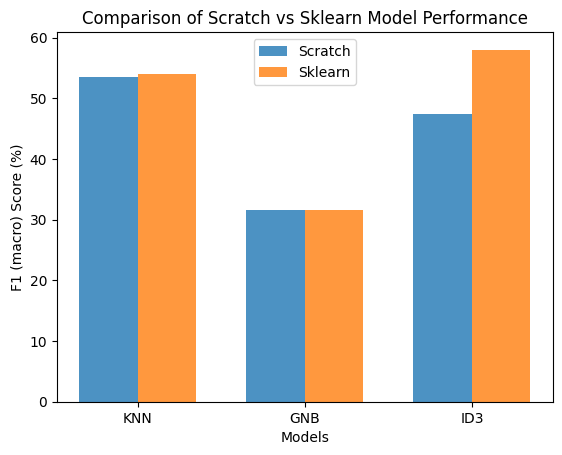

In [22]:
import matplotlib.pyplot as plt

# Data
models = ['KNN', 'GNB', 'ID3']
scratch_scores = [53.56702, 31.64350392104105, 47.42207589479325]
sklearn_scores = [54.026483727094046, 31.649347336985556, 57.98750129904408]

# Bar plot configuration
x = range(len(models))
width = 0.35

# Plotting
plt.bar(x, scratch_scores, width, label='Scratch', alpha=0.8)
plt.bar([p + width for p in x], sklearn_scores, width, label='Sklearn', alpha=0.8)

# Labels and Title
plt.xlabel('Models')
plt.ylabel('F1 (macro) Score (%)')
plt.title('Comparison of Scratch vs Sklearn Model Performance')
plt.xticks([p + width/2 for p in x], models)
plt.legend()

# Show plot
plt.show()


3. From our observation, it can be observed that it's better to impute the missing data. Dropping the missing data results in significant data loss, reducing the dataset's representativeness and statistical power to learn the pattern.

4. From our observation, we concluded that feature scaling does help the performance of our model, especially our KNN model. 

5. There was evidence of overfitting, as indicated by noticeable difference in the F1 macro scores between the validation and test sets (kaggle submission) with the model performs better in the validation setting.

6. The data imbalanced was addressed using SMOTE (oversampling) for the minority class to balance the datasets. However, this approach results in worse performance, likely due to the synthetic data not accurately representing the underlying distribution. As a result, SMOTE was not implemented in the final model.

7. There are some outliers in the data. Based on our observation, not handling outliers leads to better performance in KNN. For ID3, the impact of outliers is less significant

8. Yes, we experimented with feature selection using Random Forest and found that the number of features selected affected the model performance. By leveraging feature importance scores, we determined that selecting top 25% of features yieled performance close to optimal